# Initializing Dash for visualization

## imports

In [1]:
import os
import sys
import pandas as pd
from PIL import Image
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
import csv 
import seaborn as sns
import numpy as np
import plotly.figure_factory as ff

## Prepare the required data: teams list and NHL rink image 

In [2]:
sys.path.insert(0,'../src/data/')
from team_data import  get_all_teams 

seasons = [2016, 2017, 2018, 2019, 2020]    
game_data_dir = "../data/games/"

fname = "../data/NHL_Teams_List.csv"
img = Image.open('../figures/nhl_rink.png')  

if os.path.isfile(fname):
    teams_lst_df=pd.read_csv(fname)
    teams_lst = teams_lst_df['Teams'].values.tolist()
else:
    teams_lst = get_all_teams(data_dir="../data/raw")
    teams_lst_df = pd.DataFrame(teams_lst,columns =['Teams'])
    teams_lst_df.to_csv(fname)
    
colourscaleH=[[0, "rgba(255,255,255,0)"],[0.001, "rgba(242,231,231,0.2)"], [0.005, "rgba(229,207,207,0.4)"],[0.01, "rgba(216,182,183,0.4)"],[0.05, "rgba(203,158,159,0.4)"],
                  [0.1, "rgba(190,134,135,0.5)"],[0.2, "rgba(176,110,110,0.6)"],[0.4, "rgba(163,86,86,0.7)"],[0.6, "rgba(150,61,62,0.8)"],
                  [0.8, "rgba(125,36,37,0.9)"],[1, "rgba(125,48,48,1)"]]    
    
colourscaleC=[[0.0, "rgba(49,54,149,0.9)"],
                 [0.1111111111111111, "rgba(69,117,180,0.9)"],
                 [0.2222222222222222, "rgba(116,173,209,0.7)"],
                 [0.48, "rgba(171,217,233,0.5)"],
                 #[0.40, "rgba(255,255,255,0)"], 
                 #[0.4444444444444444, "rgba(255,255,255,0)"],
                 [0.50, "rgba(255,255,255,0)"],
                 #[0.5555555555555556, "rgba(255,255,255,0)"],
                 #[0.60, "rgba(255,255,255,0)"],
                 [0.52, "rgba(253,174,97,0.5)"],
                 [0.7777777777777778, "rgba(244,109,67,0.7)"],
                 [0.8888888888888888, "rgba(215,48,39,0.9)"],
                 [1.0, "rgba(165,0,38,0.9)"]]    

## Adding the NHL rink as background image for any plotly graph

In [3]:
def add_nhl_rink_img(fig):
        # set the axes
    fig.update_yaxes(range=[-45, 45], 
                     scaleratio = 1, 
                     scaleanchor="y",
                     showgrid=True,
                     zeroline=True,
                     showline=True,
                     gridcolor='#bdbdbd',
                     gridwidth=2,
                     zerolinecolor='#969696',
                     zerolinewidth=4,
                     linecolor='#636363',
                     linewidth=6)
    fig.update_xaxes(range=[-100, 100], 
                     scaleratio = 1, 
                     scaleanchor="x",
                     showgrid=True,
                     zeroline=True,
                     showline=True,
                     gridcolor='#bdbdbd',
                     gridwidth=2,
                     zerolinecolor='#969696',
                     zerolinewidth=4,
                     linecolor='#636363',
                     linewidth=6)

    # remove any margins and padding
    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        margin=dict(l=0, #left margin
                    r=0, #right margin
                    b=0, #bottom margin
                    t=0,  #top margin
                    pad=0
                   )
    )


    # Add the NHL rink image
    fig.add_layout_image(
            dict(
                source=img,
                xref="x",
                yref="y",
                x=0,
                y=0,
                sizex=200,
                sizey=85,
                sizing= "stretch",
                layer = "below",
                xanchor = "center",
                yanchor = "middle",
                opacity = 0.8),
    )
    return fig

## Prepare the layout: slider, dropdown lists and graph containers
for the year, team and season.

In [4]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    
    html.Div([
        "Team: ",
        dcc.Dropdown(
                    id='teams-dropdown',
                    options=[{'label': i, 'value': i} for i in teams_lst],
                    value=teams_lst[0]
                ),
        "Season: ",
        dcc.Dropdown(
                    id='seasons-dropdown',
                    options=[{'label': i, 'value': str(i)} for i in seasons],
                    value=seasons[0]
                ),
        "Sub-season: ",
        dcc.Dropdown(
                    id='sub-seasons-dropdown',
                    options=[{'label': i, 'value': i} for i in ['regular', 'postseason']],
                    value='regular'
                ),
        ],
        style={'width': '49%', 'display': 'inline-block'}),
    
    # graph for the shots distribution
    html.Div([
        html.H4(children='Shots Distribution'),
        dcc.Graph(id='nhl-rink-graph')], 
        style={'padding': 40}),
    
    
######--ATTEMPT BY TIM--######
    
    html.Div([
        html.H4(children='League Average'),
        dcc.Graph(id='nhl-league-avg-graph')],
        style={'padding': 40}),
    
    html.Div([
        html.H4(children='Team Excess Shots'),
        dcc.Graph(id='nhl-team-shot-graph')], 
        style={'padding':  40}),
    
    html.Div([
        html.H4(children='Shot Count Comparison'),
        dcc.Graph(id='nhl-team-comparison-graph')], 
        style={'padding':  40}),  
])

## Interactive Visualizing: shots, league averages and team excess shots per location

In [5]:
@app.callback(
    Output('nhl-rink-graph', 'figure'),
    
######--ATTEMPT BY TIM--######
    Output('nhl-league-avg-graph', 'figure'),
    Output('nhl-team-shot-graph', 'figure'),
    Output('nhl-team-comparison-graph', 'figure'),
                
    [Input('seasons-dropdown', 'value'),
     Input('teams-dropdown', 'value'),
     Input('sub-seasons-dropdown', 'value')])

def update_figure(selected_season, selected_team, selected_sub_season):

    # get the dataframe of the chosen team
    if selected_sub_season == 'regular':
        sub_str = '02'
    elif selected_sub_season == 'postseason':
        sub_str = '03'

    game_file_str = str(selected_season) + '-' + selected_sub_season + '.csv'
    game_df = pd.read_csv(os.path.join(game_data_dir, game_file_str))
    
    # team's data
    team_df = game_df[game_df['shooter_team_name'] == selected_team]
    team_df = team_df[team_df['home_team'] == selected_team]

    
    fig = px.scatter(team_df, x="coordinate_x", y="coordinate_y", color="shooter_name")
     
    
    fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,)),
                  selector=dict(mode='markers'))
    
    fig = add_nhl_rink_img(fig)

    
#########################################################    
    
       
######--ATTEMPT BY TIM--######

    L_game_file_str = str(selected_season) + '-' + selected_sub_season + '.csv'
    L_game_df = pd.read_csv(os.path.join(game_data_dir, L_game_file_str))

    Number_of_Teams = len(L_game_df['shooter_team_name'].unique())
    
    T_team_df = L_game_df[L_game_df['shooter_team_name'] == selected_team]
    T_team_df = T_team_df[T_team_df['home_team'] == selected_team]
 
  
#     Team2016_game_file_str = '2016-' + selected_sub_season + '.csv'    
#     Team2016_game_df = pd.read_csv(os.path.join(game_data_dir, Team2016_game_file_str))

#     Team2018_game_file_str = '2018-' + selected_sub_season + '.csv'    
#     Team2018_game_df = pd.read_csv(os.path.join(game_data_dir, Team2018_game_file_str))
    
#     Team2019_game_file_str = '2019-' + selected_sub_season + '.csv'    
#     Team2019_game_df = pd.read_csv(os.path.join(game_data_dir, Team2019_game_file_str))
      
#     Team2020_game_file_str = '2020-' + selected_sub_season + '.csv'    
#     Team2020_game_df = pd.read_csv(os.path.join(game_data_dir, Team2020_game_file_str))

    
######
    
    Cor_All_df = L_game_df[['coordinate_x','coordinate_y']]
    
    League_df = Cor_All_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
    League_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
    League_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
    League_df.rename(columns={0:'Shot Count'}, inplace = True)
    League_df["Shot Count"] = (League_df["Shot Count"]/Number_of_Teams)#.apply(np.ceil)
    

######

    Cor_Team_df = T_team_df[['coordinate_x','coordinate_y']] 
    
    Team_SC_df = Cor_Team_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
    Team_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
    Team_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
    Team_SC_df.rename(columns={0:'Shot Count'}, inplace = True)

    
    
    
######

#     Number_of_Teams_2016 = len(Team2016_game_df['shooter_team_name'].unique())
#     Cor_2016_All_df = Team2016_game_df[['coordinate_x','coordinate_y']]
    
#     League_2016_df = Cor_2016_All_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     League_2016_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     League_2016_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     League_2016_df.rename(columns={0:'Shot Count'}, inplace = True)
#     League_2016_df["Shot Count"] = (League_2016_df["Shot Count"]/Number_of_Teams_2016)
    
######

#     Number_of_Teams_2018 = len(Team2018_game_df['shooter_team_name'].unique())
#     Cor_2018_All_df = Team2018_game_df[['coordinate_x','coordinate_y']]
    
#     League_2018_df = Cor_2018_All_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     League_2018_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     League_2018_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     League_2018_df.rename(columns={0:'Shot Count'}, inplace = True)
#     League_2018_df["Shot Count"] = (League_2018_df["Shot Count"]/Number_of_Teams_2018)


######

#     Number_of_Teams_2019 = len(Team2019_game_df['shooter_team_name'].unique())
#     Cor_2019_All_df = Team2019_game_df[['coordinate_x','coordinate_y']]
    
#     League_2019_df = Cor_2019_All_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     League_2019_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     League_2019_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     League_2019_df.rename(columns={0:'Shot Count'}, inplace = True)
#     League_2019_df["Shot Count"] = (League_2019_df["Shot Count"]/Number_of_Teams_2019)

######

#     Number_of_Teams_2020 = len(Team2020_game_df['shooter_team_name'].unique())
#     Cor_2020_All_df = Team2020_game_df[['coordinate_x','coordinate_y']]
    
#     League_2020_df = Cor_2020_All_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     League_2020_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     League_2020_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     League_2020_df.rename(columns={0:'Shot Count'}, inplace = True)
#     League_2020_df["Shot Count"] = (League_2020_df["Shot Count"]/Number_of_Teams_2020)

    
        
######
    
    Team_SC_Diff_df = Team_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
    Team_SC_Diff_df = Team_SC_Diff_df.reset_index()
    
    
######
    

#     CA2016_game_df = Team2016_game_df[Team2016_game_df['shooter_team_name'] == "Colorado Avalanche"]
#     CA2016_game_df = CA2016_game_df[CA2016_game_df['home_team'] == "Colorado Avalanche"]
#     CA2016_Cor_df = CA2016_game_df[['coordinate_x','coordinate_y']]
    
#     CA2016_SC_df = CA2016_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     CA2016_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     CA2016_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     CA2016_SC_df.rename(columns={0:'Shot Count'}, inplace = True)    

#     CA2016_SC_df = CA2016_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2016_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     CA2016_SC_df = CA2016_SC_df.reset_index()
    
######

 
#     CA2020_game_df = Team2020_game_df[Team2020_game_df['shooter_team_name'] == "Colorado Avalanche"]
#     CA2020_game_df = CA2020_game_df[CA2020_game_df['home_team'] == "Colorado Avalanche"]
#     CA2020_Cor_df = CA2020_game_df[['coordinate_x','coordinate_y']]
    
#     CA2020_SC_df = CA2020_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     CA2020_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     CA2020_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     CA2020_SC_df.rename(columns={0:'Shot Count'}, inplace = True)    

#     CA2020_SC_df = CA2020_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2020_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     CA2020_SC_df = CA2020_SC_df.reset_index()
    
######
    

#     BS2018_game_df = Team2018_game_df[Team2018_game_df['shooter_team_name'] == "Buffalo Sabres"]
#     BS2018_game_df = BS2018_game_df[BS2018_game_df['home_team'] == "Buffalo Sabres"]
#     BS2018_Cor_df = BS2018_game_df[['coordinate_x','coordinate_y']]
    
#     BS2018_SC_df = BS2018_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     BS2018_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     BS2018_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     BS2018_SC_df.rename(columns={0:'Shot Count'}, inplace = True)        
    
#     BS2018_SC_df = BS2018_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2018_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     BS2018_SC_df = BS2018_SC_df.reset_index()
    
######
    

#     TBL2018_game_df = Team2018_game_df[Team2018_game_df['shooter_team_name'] == "Tampa Bay Lightning"]
#     TBL2018_game_df = TBL2018_game_df[TBL2018_game_df['home_team'] == "Tampa Bay Lightning"]
#     TBL2018_Cor_df = TBL2018_game_df[['coordinate_x','coordinate_y']]
    
#     TBL2018_SC_df = TBL2018_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     TBL2018_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     TBL2018_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     TBL2018_SC_df.rename(columns={0:'Shot Count'}, inplace = True)    

#     TBL2018_SC_df = TBL2018_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2018_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     TBL2018_SC_df = TBL2018_SC_df.reset_index()
    
######
    

#     BS2019_game_df = Team2019_game_df[Team2019_game_df['shooter_team_name'] == "Buffalo Sabres"]
#     BS2019_game_df = BS2019_game_df[BS2019_game_df['home_team'] == "Buffalo Sabres"]
#     BS2019_Cor_df = BS2019_game_df[['coordinate_x','coordinate_y']]
    
#     BS2019_SC_df = BS2019_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     BS2019_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     BS2019_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     BS2019_SC_df.rename(columns={0:'Shot Count'}, inplace = True)        
    
#     BS2019_SC_df = BS2019_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2019_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     BS2019_SC_df = BS2019_SC_df.reset_index()
    
######
    

#     TBL2019_game_df = Team2019_game_df[Team2019_game_df['shooter_team_name'] == "Tampa Bay Lightning"]
#     TBL2019_game_df = TBL2019_game_df[TBL2019_game_df['home_team'] == "Tampa Bay Lightning"]
#     TBL2019_Cor_df = TBL2019_game_df[['coordinate_x','coordinate_y']]
    
#     TBL2019_SC_df = TBL2019_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     TBL2019_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     TBL2019_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     TBL2019_SC_df.rename(columns={0:'Shot Count'}, inplace = True)       
    
#     TBL2019_SC_df = TBL2019_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2019_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     TBL2019_SC_df = TBL2019_SC_df.reset_index()    

######
    

#     BS2020_game_df = Team2020_game_df[Team2020_game_df['shooter_team_name'] == "Buffalo Sabres"]
#     BS2020_game_df = BS2020_game_df[BS2020_game_df['home_team'] == "Buffalo Sabres"]
#     BS2020_Cor_df = BS2020_game_df[['coordinate_x','coordinate_y']]
    
#     BS2020_SC_df = BS2020_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     BS2020_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     BS2020_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     BS2020_SC_df.rename(columns={0:'Shot Count'}, inplace = True)        
    
#     BS2020_SC_df = BS2020_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2020_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     BS2020_SC_df = BS2020_SC_df.reset_index()
    
######
    

#     TBL2020_game_df = Team2020_game_df[Team2020_game_df['shooter_team_name'] == "Tampa Bay Lightning"]
#     TBL2020_game_df = TBL2020_game_df[TBL2020_game_df['home_team'] == "Tampa Bay Lightning"]
#     TBL2020_Cor_df = TBL2020_game_df[['coordinate_x','coordinate_y']]
    
#     TBL2020_SC_df = TBL2020_Cor_df[["coordinate_x","coordinate_y"]].value_counts().reset_index()
#     TBL2020_SC_df.rename(columns={"coordinate_x":'X Coordinate'}, inplace = True)
#     TBL2020_SC_df.rename(columns={"coordinate_y":'Y Coordinate'}, inplace = True)
#     TBL2020_SC_df.rename(columns={0:'Shot Count'}, inplace = True)       
    
#     TBL2020_SC_df = TBL2020_SC_df.set_index(['X Coordinate','Y Coordinate']).subtract(League_2020_df.set_index(['X Coordinate','Y Coordinate']),fill_value=0)
#     TBL2020_SC_df = TBL2020_SC_df.reset_index()

    
########################   

    fig_SC_L= px.density_contour(League_df, x="X Coordinate", y="Y Coordinate",z="Shot Count", range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="League Average")

    fig_SC_L.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1  , colorscale = colourscaleH)
    fig_SC_L.data[0].update(zmin=0, zmax=20)

    # remove any margins and padding
    fig_SC_L.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

    # Add the NHL rink image
    fig_SC_L.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
    fig_SC_L.show()
      
########################    

    fig_SC_T= px.density_contour(Team_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

    fig_SC_T.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleH)
    fig_SC_T.data[0].update(zmin=0, zmax=20)

    # remove any margins and padding
    fig_SC_T.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

    # Add the NHL rink image
    fig_SC_T.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
    fig_SC_T.show()    
      
########################  

    fig_SC_C= px.density_contour(Team_SC_Diff_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Shot Count Comparison")

    fig_SC_C.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity = 1, colorscale = colourscaleC)
    fig_SC_C.data[0].update(zmin=-2, zmax=2) 


    # remove any margins and padding
    fig_SC_C.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

    # Add the NHL rink image
    fig_SC_C.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
    fig_SC_C.show()   

########################  


#     fig_SC_CA2016= px.density_contour(CA2016_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_CA2016.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_CA2016.data[0].update(zmin=-2, zmax=2) 

#     # remove any margins and padding
#     fig_SC_CA2016.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_CA2016.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
    


########################  

#     fig_SC_CA2020= px.density_contour(CA2020_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_CA2020.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_CA2020.data[0].update(zmin=-2, zmax=2) 

#     # remove any margins and padding
#     fig_SC_CA2020.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_CA2020.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)


########################  

#     fig_SC_BS2018= px.density_contour(BS2018_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_BS2018.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_BS2018.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_BS2018.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_BS2018.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
    
########################  

#     fig_SC_TBL2018= px.density_contour(TBL2018_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_TBL2018.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_TBL2018.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_TBL2018.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_TBL2018.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)




########################  

#     fig_SC_BS2019= px.density_contour(BS2019_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_BS2019.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_BS2019.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_BS2019.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_BS2019.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)


########################  

#     fig_SC_TBL2019= px.density_contour(TBL2019_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_TBL2019.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_TBL2019.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_TBL2019.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_TBL2019.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)



########################  

#     fig_SC_BS2020= px.density_contour(BS2020_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_BS2020.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_BS2020.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_BS2020.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_BS2020.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)
 

########################  

#     fig_SC_TBL2020= px.density_contour(TBL2020_SC_df, x="X Coordinate", y="Y Coordinate",z="Shot Count",range_x=[-100,100],range_y=[-43,43],histfunc="sum",nbinsx =100,nbinsy =45,title="Team Shot Count")

#     fig_SC_TBL2020.update_traces(contours_coloring="heatmap", contours_showlabels = False, opacity=1 , colorscale = colourscaleC)
#     fig_SC_TBL2020.data[0].update(zmin=-2, zmax=2)

#     # remove any margins and padding
#     fig_SC_TBL2020.update_layout(autosize=False, width=1000,height=500,margin=dict(l=0, r=0, b=0, t=0, pad=0))

#     # Add the NHL rink image
#     fig_SC_TBL2020.add_layout_image(dict(source=img,xref="x",yref="y",x=0,y=0,sizex=200,sizey=85,sizing= "stretch",layer = "below",xanchor = "center",yanchor = "middle",opacity = 1),)


########################  
    


    
    return fig, fig_SC_L, fig_SC_T, fig_SC_C 

Dash app running on http://127.0.0.1:8060/


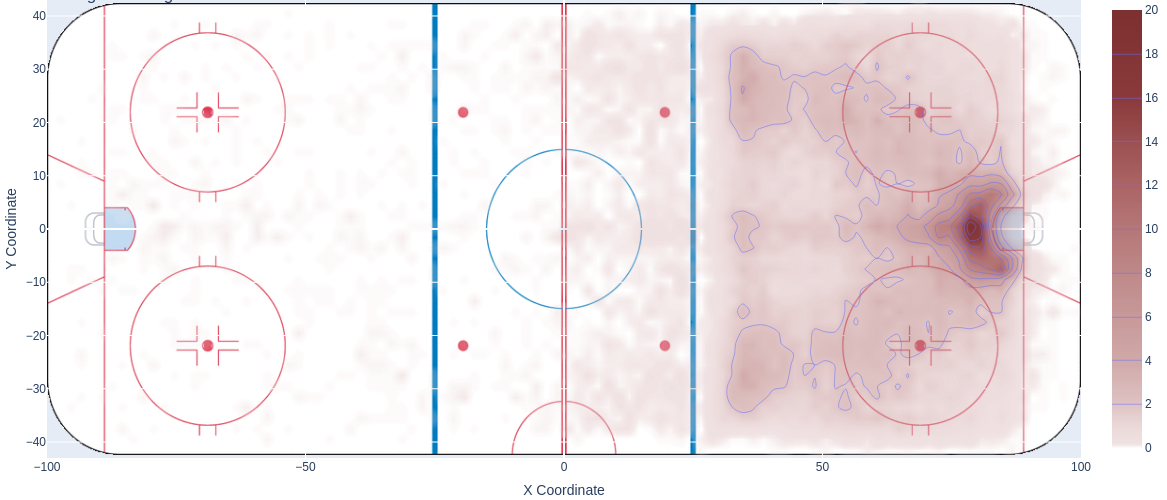

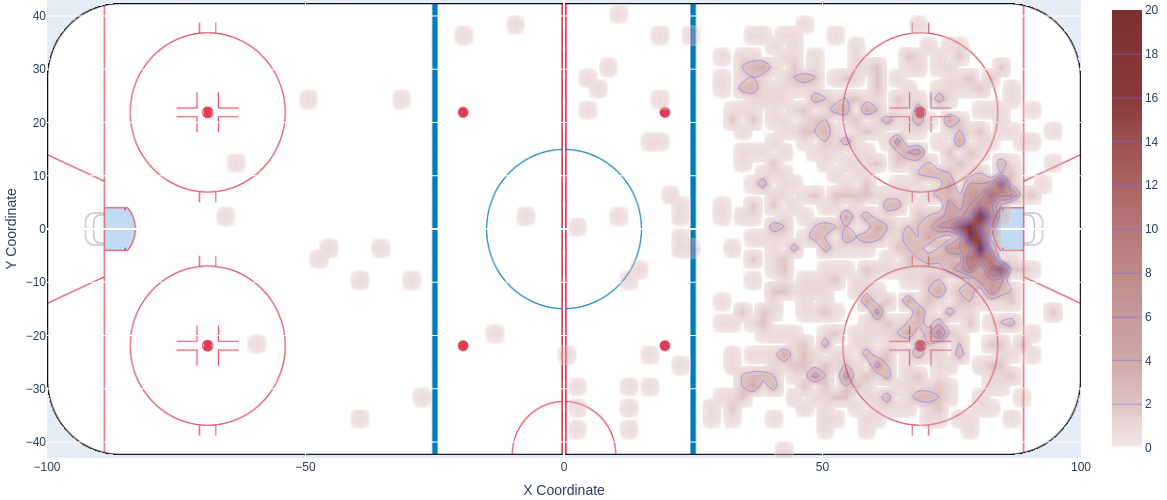

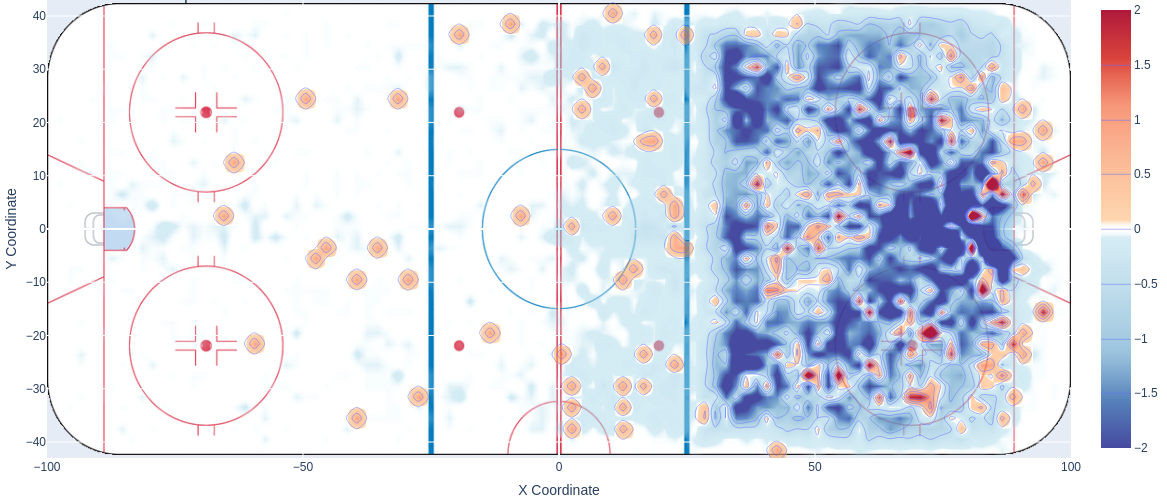

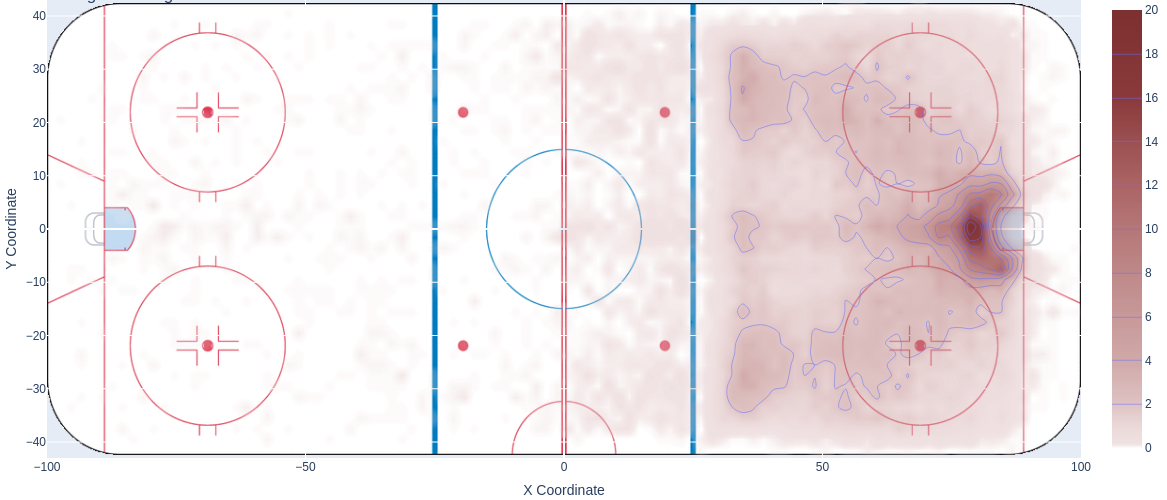

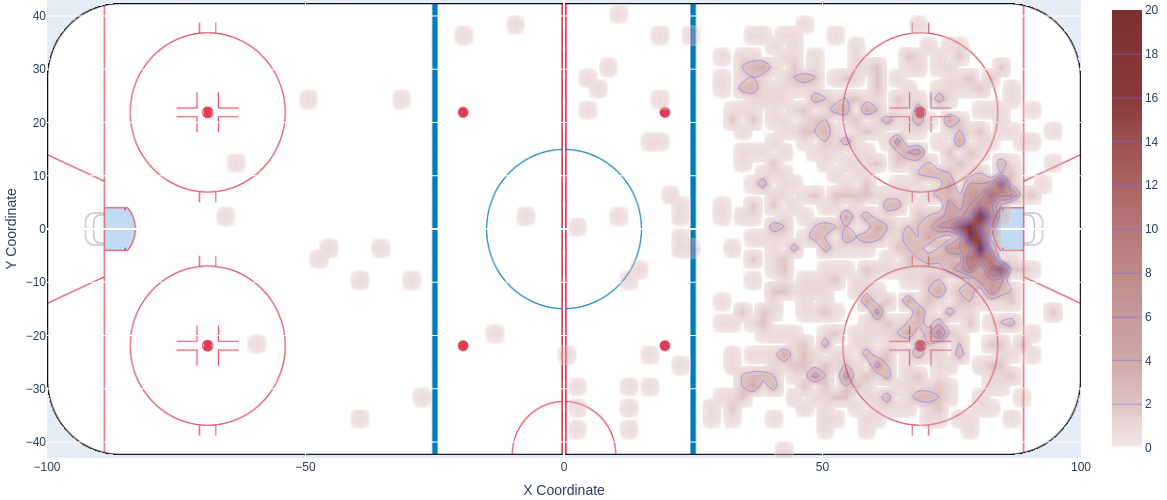

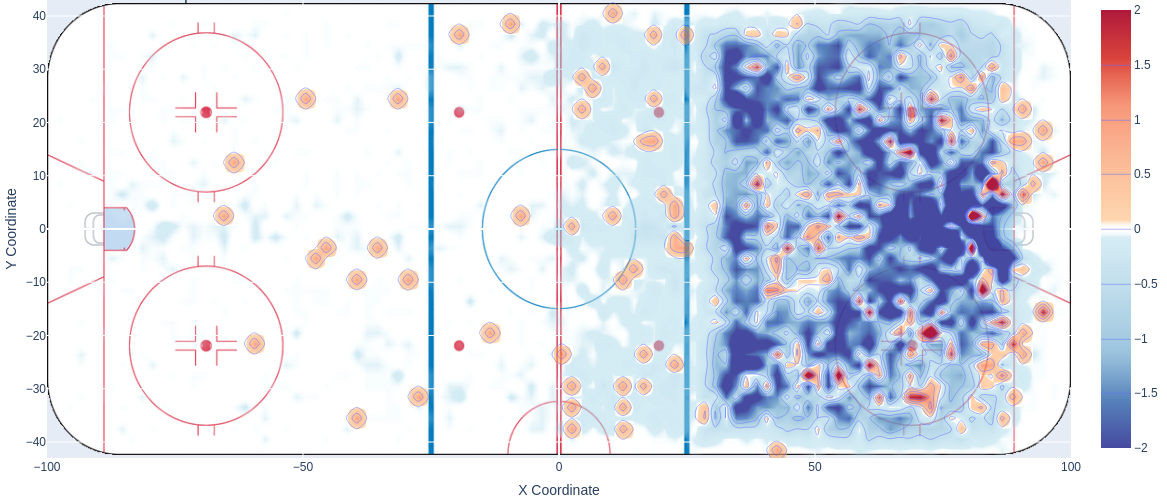

In [6]:
app.run_server(mode='external',port=8060)